## 計測誤差の実験

In [1]:
import os
import time
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize_scalar
from scipy import signal
from sklearn.metrics import r2_score, mean_squared_error
import cv2

from myfunc import delete_distance, AVE_SD_CV, plot_profile

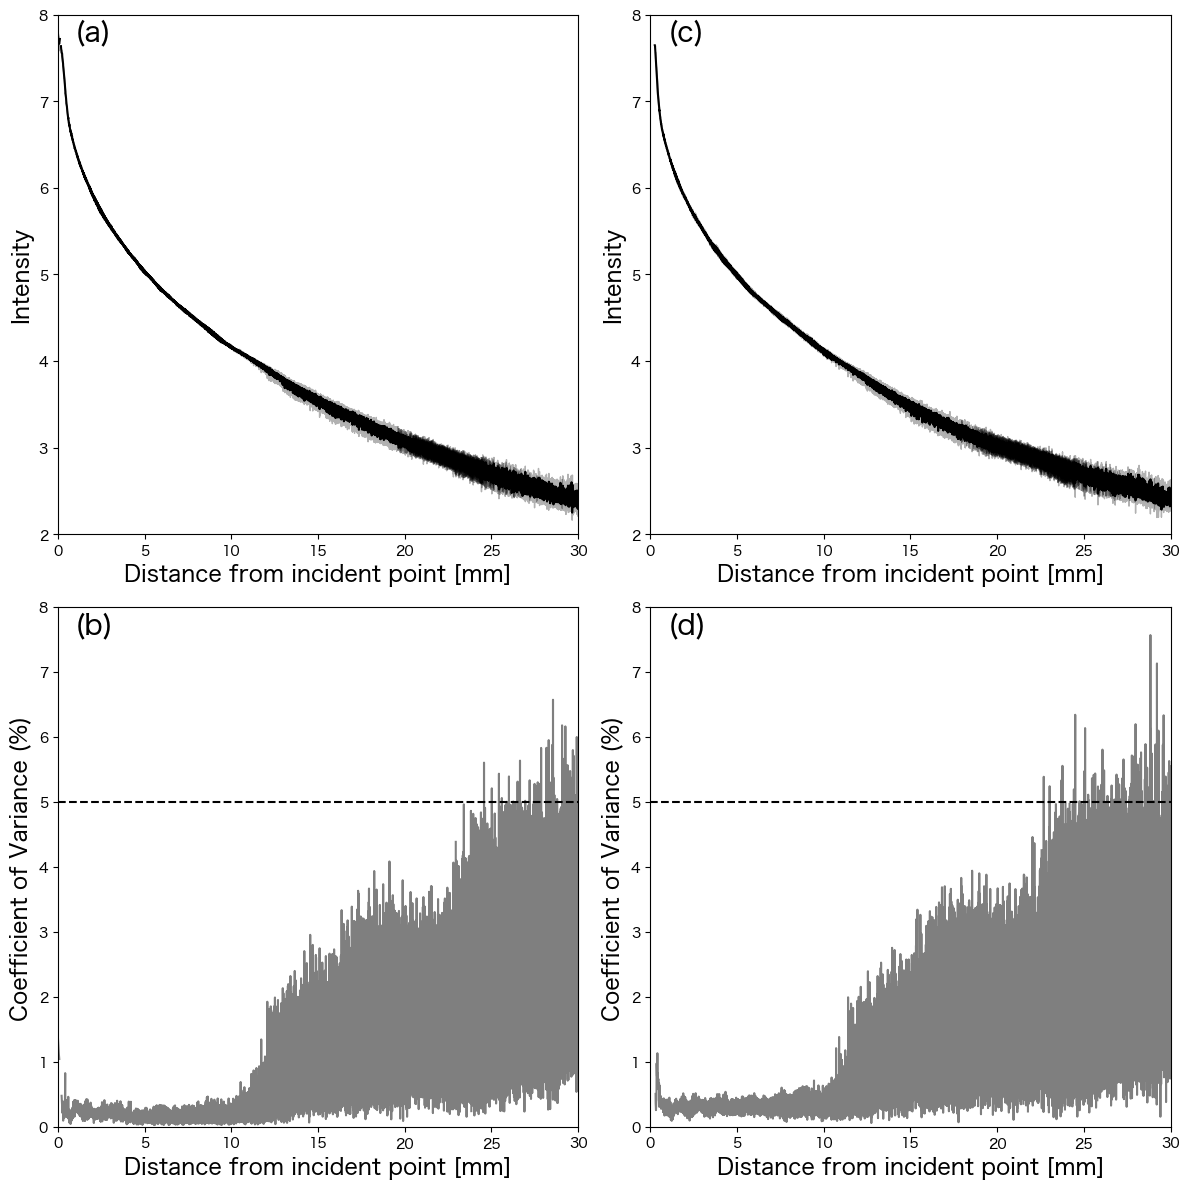

In [3]:
##### データの読み込み #####
total_df = pd.read_csv(f'./../data/allprofile.csv')

# 距離と輝度（強度）を分割
distance = total_df.iloc[:,0]
apple_df = total_df.drop('distance (mm)',axis=1)


# 解析範囲外の領域を削除
distance_30mm, apple_df_30mm = delete_distance(distance, apple_df)

# サンプルごとに分割（今回は2サンプル）
apple_1 = apple_df_30mm.iloc[:,:5]
apple_2 = apple_df_30mm.iloc[:,5:10]

# 各サンプルごとのプロファイルの平均値，標準偏差，変動係数を算出し描画
fig = plot_profile(distance=distance_30mm, data1=apple_1, data2=apple_2)
fig.savefig('./../output/図6_装置内誤差.png',dpi=400)

In [15]:
(AVE_SD_CV(apple_2)[2].min())

0.05672877662144677

## プロファイル強度比較

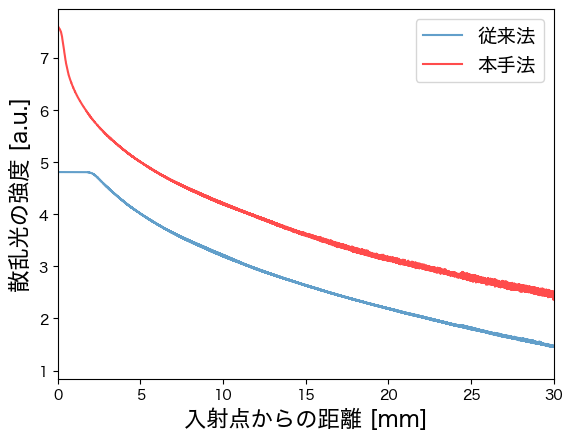

In [5]:
profile_before = pd.read_csv('./../../data/Chapter03/Conventional_Profile_633nm.csv',index_col=0)

profile_after = pd.read_csv('./../../data/Chapter03/LaserScattering_Profile_633nm.csv',index_col=0)

fig = plt.figure()
plt.plot(profile_before.index,profile_before.mean(axis=1),label='従来法',alpha=0.7)
plt.plot(profile_before.index,profile_after.mean(axis=1),label='本手法',c='r',alpha=0.7)
plt.ylabel('散乱光の強度 [a.u.]',fontsize=16)
plt.xlabel('入射点からの距離 [mm]',fontsize=16)
plt.legend(fontsize=14)
plt.xlim(0,30)
# plt.xlim(2,30)

fig.savefig('./../../output/Chapter03/図9_プロファイルの強度比較.png',dpi=400)

## プロファイルの形状比較

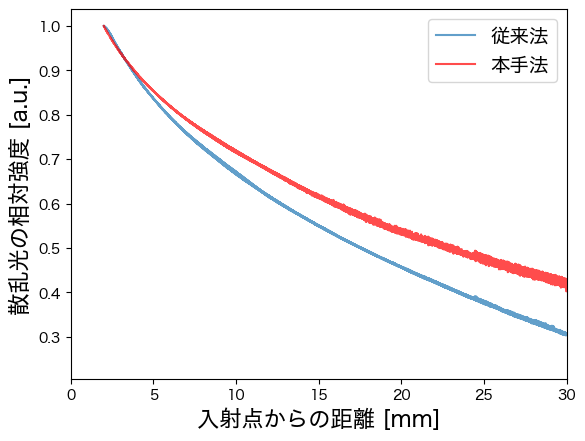

In [6]:
# 規格化前
profile_before_norm = (profile_before.mean(axis=1))[np.array(profile_before.mean(axis=1).index.tolist())>2]
profile_after_norm = profile_after.mean(axis=1)[np.array(profile_after.mean(axis=1).index.tolist())>2]
profile_before_norm = profile_before_norm/profile_before_norm.max()
profile_after_norm = profile_after_norm/profile_after_norm.max()

fig = plt.figure()
plt.plot(profile_before_norm.index,profile_before_norm,label='従来法',alpha=0.7)
plt.plot(profile_after_norm.index,profile_after_norm,label='本手法',c='r',alpha=0.7)
plt.ylabel('散乱光の相対強度 [a.u.]',fontsize=16)
plt.xlabel('入射点からの距離 [mm]',fontsize=16)
plt.legend(fontsize=14)
plt.xlim(0,30)

fig.savefig('./../../output/Chapter03/図10_プロファイルの形状比較.png',dpi=400)

## 後方散乱画像の比較

### 散乱面積の比較

In [7]:
area_after_list = []
area_before_list  =[]
area_ratio_list = []

for i_app in [str(i).zfill(2) for i in range(1,11)]:
    for i_num in range(1,5):
        
        # 画像の読み込み
        img_before = cv2.imread(f'./../../data/Chapter03/Conventional_Image_633nm/02_{i_app}_{i_num}.png',-1)    
        img_after  = cv2.imread(f'./../../data/Chapter03/LaserScattering_Image_633nm/02_{i_app}_{i_num}.png',-1)
        
        # 平滑化
        img_before_smooth = cv2.GaussianBlur(img_before,(15,15),5)
        img_after_smooth = cv2.GaussianBlur(img_after,(15,15),5)

        # 2値化
        thresh_before, img_before_binary = cv2.threshold(img_before_smooth, 0, img_before_smooth.max(), cv2.THRESH_OTSU)
        thresh_after, img_after_binary = cv2.threshold(img_after_smooth, 0, img_after_smooth.max(), cv2.THRESH_OTSU)

        # mask処理
        mask_before = np.where(img_before_smooth<thresh_before, 0, img_before)
        mask_after = np.where(img_after_smooth<thresh_after, 0, img_after)

        # 飽和散乱光の除去
        mask_del_before = np.where(mask_before>=img_before_smooth.max(), 0, mask_before) # 飽和している場所は0にする処理（ROIから除去）
        mask_del_after  = np.where(mask_after>=img_after_smooth.max(),0, mask_after) # 飽和している場所は0にする処理（ROIから除去）

        # 面積作成
        area_before = len(mask_del_before[mask_del_before>0]) # mask_del_imgの0以上の強度のみ算出
        area_after  = len(mask_del_after[mask_del_after>0]) # mask_del_imgの0以上の強度のみ算出
        
        # 面積および比較結果の格納
        area_before_list.append(area_before)
        area_after_list.append(area_after)
        area_ratio_list.append(area_after/area_before)

print(f'{np.mean(area_ratio_list):.2f}±{np.std(area_ratio_list):.2f}倍')

1.00±0.00倍


### 後方散乱画像の比較

True

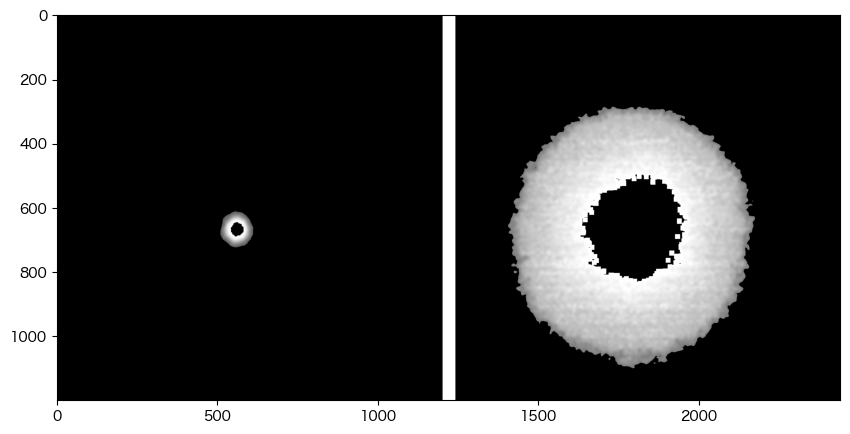

In [16]:
#　画像の読み込み
img_before = cv2.imread('./../data/Conventional_Image_633nm/02_02_4.png',-1)
img_after  = cv2.imread('./../data/LaserScattering_Image_633nm//02_02_4.png',-1)

#　平滑化
img_before_smooth = cv2.GaussianBlur(img_before,(15,15),5)
img_after_smooth = cv2.GaussianBlur(img_after,(15,15),5)

# 2値化
thresh_before, img_before_binary = cv2.threshold(img_before_smooth, 0, img_before_smooth.max(), cv2.THRESH_OTSU)
thresh_after, img_after_binary = cv2.threshold(img_after_smooth, 0, img_after_smooth.max(), cv2.THRESH_OTSU)

# mask処理
mask_before = np.where(img_before_smooth<thresh_before, 0, img_before_smooth)
mask_after = np.where(img_after_smooth<thresh_after, 0, img_after_smooth)

# 飽和散乱光の除去
mask_del_before = np.where(mask_before==img_before_smooth.max(), 0, mask_before) # 飽和している場所は0にする処理（ROIから除去）
mask_del_after  = np.where(mask_after==img_after_smooth.max(),0, mask_after) # 飽和している場所は0にする処理（ROIから除去）

# 画像の比較
# 画像間の間を設定
height = mask_del_after.shape[0]
blank = np.zeros((height, 40), np.uint16)
blank += 2**16-1 #0配列は黒なので全要素を2^16にする

fig = plt.figure(figsize=(15,5))
temp = cv2.hconcat([mask_del_before,blank])
all_im = cv2.hconcat([temp,mask_del_after])

plt.imshow(all_im,cmap='gray')

cv2.imwrite('./../output/図11_両手法の代表的後方散乱画像の比較_規格化後.png',all_im)

### 後方散乱画像のヒストグラムを比較

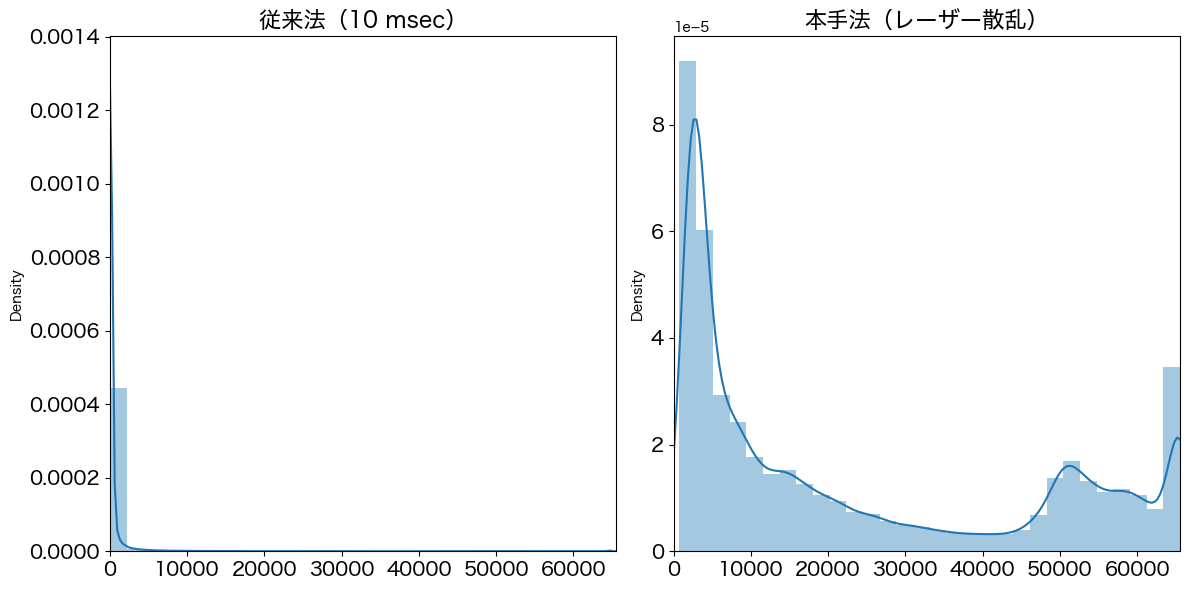

In [12]:
import seaborn as sns

fig = plt.figure(figsize=(12,6))

# 従来法
plt.subplot(121)
sns.distplot(img_before_smooth.flatten(),bins=30)
plt.title('従来法（10 msec）',fontsize=16)
plt.xlim(0,2**16-1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# レーザー散乱
plt.subplot(122)
sns.distplot(img_after_smooth.flatten(),bins=30)
plt.title('本手法（レーザー散乱）',fontsize=16)
plt.xlim(0,2**16-1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('./../../output/Chapter03/図12_比較_ヒストグラム.png',dpi=400)